# Deep Q-learning for GridWorld - Complete code


In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Gridworld import Gridworld
import copy
import os

##### Vanilla Model

In [2]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [3]:
# Balanced DQN model - lighter regularization
class BalancedDQN(torch.nn.Module):
    def __init__(self, input_dim=29, output_dim=4):
        super(BalancedDQN, self).__init__()
        # First layer with lighter dropout
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.dropout1 = torch.nn.Dropout(0.1)  # Reduced dropout (10%)
        
        # Second layer with lighter dropout
        self.fc2 = torch.nn.Linear(128, 128)
        self.dropout2 = torch.nn.Dropout(0.1)  # Reduced dropout (10%)
        
        # Output layer
        self.fc3 = torch.nn.Linear(128, output_dim)
        
    def forward(self, x):
        # No batch normalization, which can be destabilizing for RL
        # Simple clean forward pass with minimal regularization
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
            
        x = torch.nn.functional.relu(self.fc1(x))
        # Only use dropout during training
        if self.training:
            x = self.dropout1(x)
        
        x = torch.nn.functional.relu(self.fc2(x))
        if self.training:
            x = self.dropout2(x)
            
        return self.fc3(x)
    
model = BalancedDQN(input_dim=29, output_dim=4)
    
loss_fn = torch.nn.MSELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

###### Target network to handle learning instability

## DQN Training with Experience Replay and Target Network

In [4]:
# Create main network and target network
model2 = copy.deepcopy(model)  # Target network

# Loss function and optimizer
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training hyperparameters
gamma = 0.99      # Discount factor
epsilon = 1.0     # Initial exploration rate
epsilon_min = 0.1 # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration

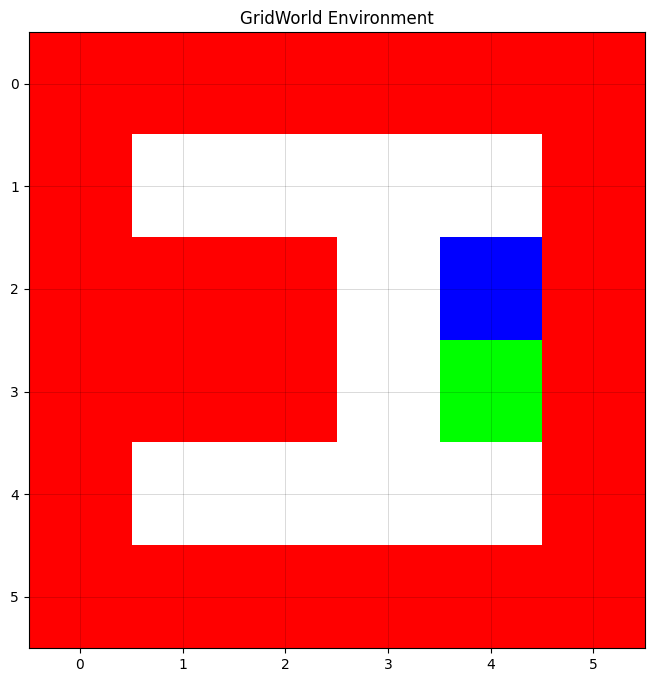

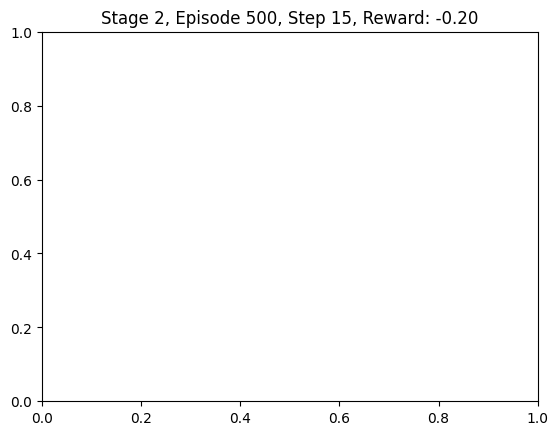

Episode 500: Success! Reward: 9.40, Steps: 19
Checkpoint saved at episode 500
Episode 501: Success! Reward: 10.20, Steps: 7
Episode 502: Success! Reward: -3.60, Steps: 21
Episode 503: Success! Reward: 9.00, Steps: 15
Episode 504: Success! Reward: 8.60, Steps: 18
Episode 505: Success! Reward: 10.40, Steps: 2
Episode 506: Success! Reward: 9.80, Steps: 8
Episode 507: Success! Reward: -2.60, Steps: 21
Episode 508: Success! Reward: 9.60, Steps: 15
Episode 509: Success! Reward: 9.80, Steps: 2
Episode 510: Success! Reward: 9.80, Steps: 17
Episode 511: Success! Reward: -2.60, Steps: 21
Episode 512: Success! Reward: -3.60, Steps: 21
Episode 513: Success! Reward: -3.20, Steps: 21
Episode 514: Success! Reward: -1.60, Steps: 21
Episode 515: Success! Reward: -3.40, Steps: 21
Episode 516: Success! Reward: 10.60, Steps: 5
Episode 517: Success! Reward: 9.60, Steps: 4
Episode 518: Success! Reward: -2.00, Steps: 21
Episode 519: Success! Reward: 8.60, Steps: 15
Episode 520: Success! Reward: 9.20, Steps: 

KeyboardInterrupt: 

In [5]:
# Enhanced Compound Training Function
def train_compound(epochs=24000, batch_size=64, memory_size=150000, render_interval=500):
    # Initialize metrics tracking
    losses = []
    all_rewards = []
    avg_rewards = []
    success_rates = []
    best_eval_score = float('-inf')
    best_model_state = None
    
    # Create replay memory
    replay = deque(maxlen=memory_size)
    
    # Create model checkpoint directory
    os.makedirs('models', exist_ok=True)

    # Initialize epsilon for exploration
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay_rate = 0.99995  # Slower decay for more exploration
    
    # Enhanced curriculum with more intermediate stages and higher obstacle density
    curriculum = [
        # Stage 1: Very small grids (5x5) with minimal obstacles
        {'episodes': int(epochs * 0.02), 'grid_sizes': [5], 'obstacles': (1, 3), 'patterns': ['random'], 
        'max_steps_factor': 3.5, 'epsilon_min': 0.2},
        
        # Stage 2: Small grids (6x6) with increasing obstacles
        {'episodes': int(epochs * 0.03), 'grid_sizes': [6], 'obstacles': (2, 4), 'patterns': ['random'], 
        'max_steps_factor': 3.5, 'epsilon_min': 0.18},
        
        # Stage 3: Small grids (7x7, 8x8) with more obstacles
        {'episodes': int(epochs * 0.04), 'grid_sizes': [7, 8], 'obstacles': (3, 6), 'patterns': ['random'], 
        'max_steps_factor': 3.2, 'epsilon_min': 0.16},
        
        # Stage 4: Early medium grids (9x9, 10x10) with moderate obstacles
        {'episodes': int(epochs * 0.05), 'grid_sizes': [9, 10], 'obstacles': (4, 8), 'patterns': ['random'], 
        'max_steps_factor': 3.0, 'epsilon_min': 0.15},
        
        # Stage 5: Medium grids (11x11, 12x12) with clusters
        {'episodes': int(epochs * 0.05), 'grid_sizes': [11, 12], 'obstacles': (5, 10), 'patterns': ['random'],
        'max_steps_factor': 2.8, 'epsilon_min': 0.14},
        
        # Stage 6: Larger medium grids (13x13, 14x14) with more obstacles
        {'episodes': int(epochs * 0.06), 'grid_sizes': [13, 14], 'obstacles': (8, 14), 'patterns': ['random'],
        'max_steps_factor': 2.8, 'epsilon_min': 0.13},
        
        # Stage 7: Medium-large grids (15x15, 16x16) with substantial obstacles 
        {'episodes': int(epochs * 0.07), 'grid_sizes': [15, 16], 'obstacles': (10, 15), 'patterns': ['random'],
        'max_steps_factor': 2.6, 'epsilon_min': 0.12},
        
        # Stage 8: Large medium grids (17x17, 18x18) introducing walls pattern
        {'episodes': int(epochs * 0.07), 'grid_sizes': [17, 18], 'obstacles': (12, 16), 'patterns': ['random'],
        'max_steps_factor': 2.6, 'epsilon_min': 0.11},
        
        # Stage 9: First large grids (19x19, 20x20) with challenging obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [19, 20], 'obstacles': (15, 18), 'patterns': ['random'],
        'max_steps_factor': 2.5, 'epsilon_min': 0.10},
        
        # Stage 10: Growing large grids (22x22, 24x24) with dense obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [22, 24], 'obstacles': (18, 20), 'patterns': ['random'],
        'max_steps_factor': 2.4, 'epsilon_min': 0.09},
        
        # Stage 11: Large grids (25x25, 27x27) with very high obstacle count
        {'episodes': int(epochs * 0.08), 'grid_sizes': [25, 27], 'obstacles': (21, 24), 'patterns': ['random'],
        'max_steps_factor': 2.3, 'epsilon_min': 0.08},
        
        # Stage 12: Very large grids (30x30) with maze-like obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [30], 'obstacles': (24, 30), 'patterns': ['random'],
        'max_steps_factor': 2.2, 'epsilon_min': 0.07},
        
        # Stage 13: Larger grids (33x33, 35x35) with high obstacle density
        {'episodes': int(epochs * 0.08), 'grid_sizes': [33, 35], 'obstacles': (25, 35), 'patterns': ['random'],
        'max_steps_factor': 2.1, 'epsilon_min': 0.06},
        
        # Stage 14: Extremely large grids (38x38) with extreme obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [38], 'obstacles': (30, 40), 'patterns': ['random'],
        'max_steps_factor': 2.0, 'epsilon_min': 0.055},
        
        # Stage 15: Maximum challenge (40x40) with highest obstacle density
        {'episodes': int(epochs * 0.13), 'grid_sizes': [40], 'obstacles': (20, 50), 'patterns': ['random'],
        'max_steps_factor': 2.0, 'epsilon_min': 0.05}
    ]
    
    # Setup for periodic evaluation
    eval_interval = 200  # Evaluate model every 200 episodes
    eval_episodes = 20   # Number of episodes to use for evaluation
    
    # Validation environments for consistent evaluation
    validation_envs = [
        # Simple validation environments
        (10, 5, 'random'),   # (grid_size, obstacles, pattern)
        (15, 10, 'random'),
        (20, 15, 'clusters'),
        (30, 20, 'walls'),
        (40, 30, 'random')
    ]

    # Define sync frequency for target network updates (steps)
    sync_freq = 1000
    
    # Global step counter
    global_step = 0
    episode_count = 0
    
    print("Starting compound training with curriculum learning...")
    
    # Loop through curriculum stages
    for stage_idx, stage in enumerate(curriculum):
        print(f"\n===== Starting Stage {stage_idx + 1}/{len(curriculum)} =====")
        print(f"Grid sizes: {stage['grid_sizes']}")
        print(f"Obstacles: {stage['obstacles']}")
        print(f"Patterns: {stage['patterns']}")
        print(f"Episodes: {stage['episodes']}")
        
        # Update epsilon min for this stage
        stage_epsilon_min = stage['epsilon_min']
        
        # Reset epsilon for new stage if needed (optional - keep this line if you want epsilon reset per stage)
        epsilon = max(1.0 - stage_idx * 0.1, 0.5)  # Start with less exploration in later stages
        
        # Track episodes in this stage
        stage_episodes = 0
        
        # Continue until we've completed the designated episodes for this stage
        while stage_episodes < stage['episodes'] and episode_count < epochs:
            # Select random parameters for this episode
            grid_size = random.choice(stage['grid_sizes'])
            num_obstacles = random.randint(stage['obstacles'][0], stage['obstacles'][1])
            pattern = random.choice(stage['patterns'])
            episode_seed = episode_count + random.randint(10000, 50000)
            
            # Create environment for this episode
            max_steps = int(grid_size * stage['max_steps_factor'])  # Scale max steps with grid size
            game = Gridworld(size=grid_size, mode=pattern, num_obstacles=num_obstacles, max_steps=max_steps, random_seed=episode_seed)
            
            # Initialize state
            state = game.reset()
            state = torch.from_numpy(state).float().unsqueeze(0)  # Add batch dimension
            
            done = False
            steps = 0
            episode_reward = 0
            success = False
            
            # Display info periodically
            should_render = (episode_count % render_interval == 0)
            
            if episode_count % 50 == 0:
                print(f"Episode {episode_count}/{epochs} (Stage {stage_idx+1}, Ep {stage_episodes}/{stage['episodes']})")
                print(f"Grid: {grid_size}x{grid_size}, Obstacles: {num_obstacles}, Pattern: {pattern}")
                print(f"Epsilon: {epsilon:.4f}, Memory: {len(replay)}/{memory_size}")
            
            # Run episode
            while not done and steps < max_steps:
                steps += 1
                global_step += 1
                
                # Epislon-greedy action selection
                if random.random() < epsilon:
                    action = random.randint(0, 3)  # Random action
                else:
                    with torch.no_grad():
                        q_values = model(state)
                        action = torch.argmax(q_values).item()  # Greedy action
                
                # Take action in environment
                next_state, reward, done, info = game.step(action)
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                
                # Record success if goal reached
                if reward > 0:  # Assuming positive reward means goal reached
                    success = True
                
                # Store in replay memory
                replay.append((state, action, reward, next_state, done))
                
                # Update state and accumulate reward
                state = next_state
                episode_reward += reward
                
                # Render if needed
                if should_render and steps % 5 == 0:
                    clear_output(wait=True)
                    game.render()
                    plt.title(f"Stage {stage_idx+1}, Episode {episode_count}, Step {steps}, Reward: {episode_reward:.2f}")
                    plt.pause(0.1)
                
                # Training step (if we have enough samples)
                if len(replay) >= batch_size:
                    # Sample mini-batch
                    minibatch = random.sample(replay, batch_size)
                    
                    # Extract batch components
                    state_batch = torch.cat([s1 for (s1, _, _, _, _) in minibatch])
                    action_batch = torch.tensor([a for (_, a, _, _, _) in minibatch], dtype=torch.long)
                    reward_batch = torch.tensor([r for (_, _, r, _, _) in minibatch], dtype=torch.float)
                    next_state_batch = torch.cat([s2 for (_, _, _, s2, _) in minibatch])
                    done_batch = torch.tensor([d for (_, _, _, _, d) in minibatch], dtype=torch.float)
                    
                    # Compute current Q values
                    current_Q = model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
                    
                    # Double DQN: Use online network to select actions, target network to evaluate
                    with torch.no_grad():
                        # Find best actions using online model
                        best_actions = model(next_state_batch).max(1)[1].unsqueeze(1)
                        # Evaluate those actions using target model
                        next_Q = model2(next_state_batch).gather(1, best_actions).squeeze(1)
                        # Compute target Q values
                        target_Q = reward_batch + gamma * next_Q * (1 - done_batch)
                    
                    # Compute loss and update model
                    loss = loss_fn(current_Q, target_Q)
                    optimizer.zero_grad()
                    loss.backward()
                    
                    # Gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                    
                    optimizer.step()
                    
                    # Store loss
                    losses.append(loss.item())
                
                # Update target network
                if global_step % sync_freq == 0:
                    model2.load_state_dict(model.state_dict())
                    print(f"Target network updated at step {global_step}")
            
            # Episode completed
            all_rewards.append(episode_reward)
            
            # Calculate running average reward
            window_size = min(100, len(all_rewards))
            avg_reward = sum(all_rewards[-window_size:]) / window_size
            avg_rewards.append(avg_reward)
            
            # Print episode results
            if success:
                print(f"Episode {episode_count}: Success! Reward: {episode_reward:.2f}, Steps: {steps}")
            elif episode_count % 50 == 0:
                print(f"Episode {episode_count}: Failed. Reward: {episode_reward:.2f}, Steps: {steps}")
            
            # Evaluate periodically
            if episode_count % eval_interval == 0 and episode_count > 0:
                print("\nRunning evaluation...")
                eval_success_rate, eval_avg_reward = evaluate_model(model, validation_envs, episodes_per_env=eval_episodes)
                success_rates.append(eval_success_rate)
                
                print(f"Evaluation - Success rate: {eval_success_rate:.2f}, Avg reward: {eval_avg_reward:.2f}")
                
                # Save best model
                eval_score = eval_success_rate * 10 + eval_avg_reward  # Combined metric
                if eval_score > best_eval_score:
                    best_eval_score = eval_score
                    best_model_state = model.state_dict().copy()
                    print(f"New best model with eval score {eval_score:.2f}!")
                    
                    # Save best model
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epsilon': epsilon,
                        'episode': episode_count,
                        'eval_score': eval_score,
                        'success_rate': eval_success_rate,
                        'avg_reward': eval_avg_reward,
                    }, 'models/dqn_best.pth')
            
            # Checkpoint model periodically
            if episode_count % 500 == 0 and episode_count > 0:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epsilon': epsilon,
                    'episode': episode_count,
                    'stage': stage_idx,
                    'all_rewards': all_rewards,
                    'avg_rewards': avg_rewards,
                    'losses': losses,
                }, f'models/dqn_checkpoint_ep{episode_count}.pth')
                print(f"Checkpoint saved at episode {episode_count}")
            
            # Decay epsilon - but respect the minimum for this stage
            epsilon = max(stage_epsilon_min, epsilon * epsilon_decay_rate)
            
            # Increment counters
            episode_count += 1
            stage_episodes += 1
        
        # End of stage - evaluate and save stage model
        print(f"\n===== Completed Stage {stage_idx + 1}/{len(curriculum)} =====")
        stage_eval_success, stage_eval_reward = evaluate_model(model, validation_envs, episodes_per_env=eval_episodes)
        
        print(f"Stage {stage_idx+1} Evaluation - Success rate: {stage_eval_success:.2f}, Avg reward: {stage_eval_reward:.2f}")
        
        # Save stage model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode_count,
            'stage': stage_idx,
            'success_rate': stage_eval_success,
            'avg_reward': stage_eval_reward,
        }, f'models/dqn_stage{stage_idx+1}.pth')
    
    # Training complete - final evaluation with best model
    print("\n===== Training Complete =====")
    
    # Load best model for final evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model for final evaluation")
    
    # Comprehensive final evaluation
    print("\nRunning final evaluation...")
    final_success_rate, final_avg_reward = evaluate_model(model, validation_envs, episodes_per_env=50)  # More episodes for final eval
    
    print(f"Final Evaluation - Success rate: {final_success_rate:.2f}, Avg reward: {final_avg_reward:.2f}")
    
    # Plot training metrics
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(all_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(2, 2, 2)
    plt.plot(avg_rewards)
    plt.title('Average Reward (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    
    plt.subplot(2, 2, 3)
    plt.plot(losses[-10000:])  # Plot last 10000 losses to see recent trends
    plt.title('Training Loss (last 10000 updates)')
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    
    if success_rates:
        plt.subplot(2, 2, 4)
        # Generate x values that match exactly with the length of success_rates
        eval_points = np.arange(eval_interval, eval_interval * (len(success_rates) + 1), eval_interval)[:len(success_rates)]
        plt.plot(eval_points, success_rates)
        plt.title('Evaluation Success Rate')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')
    
    plt.tight_layout()
    plt.savefig('models/training_curves.png')
    plt.show()
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epsilon': epsilon,
        'episode': episode_count,
        'final_success_rate': final_success_rate,
        'final_avg_reward': final_avg_reward,
    }, 'models/dqn_final.pth')
    
    # Return relevant data for analysis
    return {
        'model': model,
        'rewards': all_rewards,
        'avg_rewards': avg_rewards,
        'losses': losses,
        'success_rates': success_rates,
        'final_success_rate': final_success_rate,
        'final_avg_reward': final_avg_reward,
        'best_eval_score': best_eval_score
    }

def evaluate_model(model, env_configs, episodes_per_env=10):
    """
    Evaluate model on multiple environment configurations
    
    Args:
        model: The DQN model to evaluate
        env_configs: List of tuples (grid_size, num_obstacles, pattern)
        episodes_per_env: Number of episodes to run for each environment config
        
    Returns:
        Tuple of (success_rate, average_reward)
    """
    model.eval()  # Set model to evaluation mode
    success_count = 0
    total_rewards = []
    total_episodes = len(env_configs) * episodes_per_env
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for grid_size, num_obstacles, pattern in env_configs:
            print(f"Evaluating on grid {grid_size}x{grid_size}, {num_obstacles} obstacles, {pattern} pattern")
            
            for ep in range(episodes_per_env):
                # Create environment
                max_steps = grid_size * 2
                game = Gridworld(size=grid_size, mode=pattern, num_obstacles=num_obstacles, max_steps=max_steps)
                
                state = game.reset()
                state = torch.from_numpy(state).float().unsqueeze(0)
                
                done = False
                steps = 0
                episode_reward = 0
                success = False
                
                while not done and steps < max_steps:
                    steps += 1
                    
                    # Get action from model - no exploration during evaluation
                    q_values = model(state)
                    action = torch.argmax(q_values).item()
                    
                    # Take action
                    next_state, reward, done, info = game.step(action)
                    next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                    
                    # Update state and reward
                    state = next_state
                    episode_reward += reward
                    
                    # Check for success
                    if reward > 0:  # Positive reward means goal reached
                        success = True
                        break
                
                # Record results
                if success:
                    success_count += 1
                total_rewards.append(episode_reward)
    
    # Calculate final metrics
    success_rate = success_count / total_episodes
    avg_reward = sum(total_rewards) / len(total_rewards)
    
    model.train()  # Set model back to training mode
    return success_rate, avg_reward

epochs = 24000
results = train_compound(epochs=epochs, batch_size=64, memory_size=50000, render_interval=500)
model = results['model']

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epsilon': epsilon,
    'episode': epochs,
}, 'models/dqn_final.pth')
print("Training completed. Final model saved.")

## Testing The Trained Model

<Figure size 1000x1000 with 0 Axes>

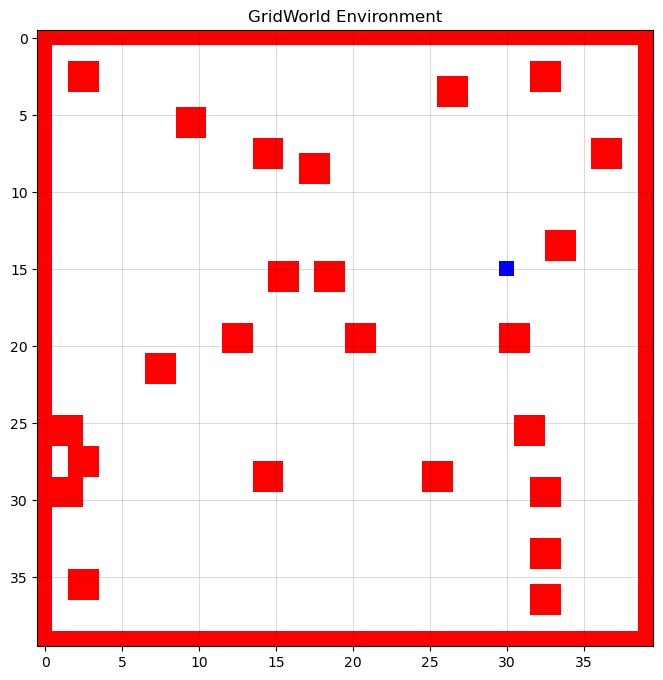

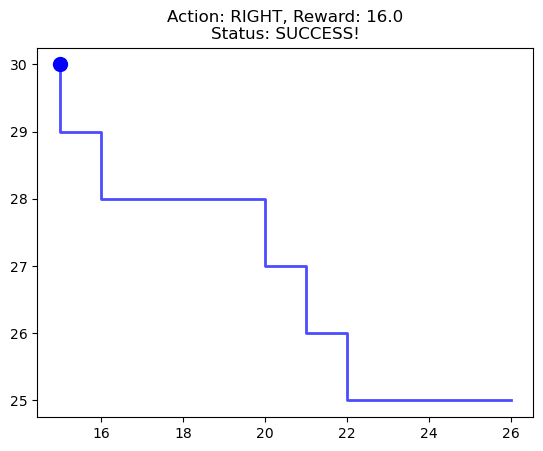


===== TEST RESULTS =====
Agent Type: DQN
Random Seed: 1
Goal Reached: Yes
Total Timesteps: 16
Total Distance: 16
Unique Locations: 17
Revisited Locations: 0
Shannon Entropy (states): 0.956
Grid Dimensions: 40x40

Action distribution:
  UP: 11 times (68.8%)
  RIGHT: 5 times (31.2%)

Most visited states:
  (25, 26): 1 visits
  (25, 25): 1 visits
  (25, 24): 1 visits
  (25, 23): 1 visits
  (25, 22): 1 visits
Episode 2: ✅ SUCCESS - Seed: 2, Timesteps: 39, Distance: 39, Shannon Entropy: 0.95
Episode 3: ✅ SUCCESS - Seed: 3, Timesteps: 51, Distance: 51, Shannon Entropy: 0.95
Episode 4: ✅ SUCCESS - Seed: 4, Timesteps: 20, Distance: 20, Shannon Entropy: 0.96
Episode 5: ✅ SUCCESS - Seed: 5, Timesteps: 21, Distance: 21, Shannon Entropy: 0.96
Episode 6: ❌ FAILED - Seed: 6, Timesteps: 200, Distance: 6, Shannon Entropy: 1.69
Episode 7: ❌ FAILED - Seed: 7, Timesteps: 200, Distance: 9, Shannon Entropy: 1.65
Episode 8: ❌ FAILED - Seed: 8, Timesteps: 200, Distance: 29, Shannon Entropy: 1.47
Episode 9: 

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output
import os
from collections import Counter
import math

# Try to import the Gridworld environment
try:
    from Gridworld import Gridworld
except ImportError:
    try:
        from New_RL.Gridworld import Gridworld
    except ImportError:
        print("Error: Couldn't import Gridworld. Please check your import paths.")

# Define DQN model architecture (simplified)
class DQN(torch.nn.Module):
    def __init__(self, input_dim=29, output_dim=4):
        super(DQN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        return self.fc3(x)

def load_model(model_path, input_dim=29, output_dim=4, device='cpu'):
    """
    Load a DQN model from a checkpoint file.
    """
    try:
        # Create the model with specified dimensions
        model = DQN(input_dim=input_dim, output_dim=output_dim).to(device)
        
        # Load the checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        
        # Extract model state from checkpoint
        if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
            model_state = checkpoint["model_state_dict"]
            print(f"Model checkpoint contains: {list(checkpoint.keys())}")
            if "episode" in checkpoint:
                print(f"Model was trained for {checkpoint['episode']} episodes")
        else:
            model_state = checkpoint
            print("Model state loaded directly")
        
        # Load state dict into model
        model.load_state_dict(model_state)
        model.eval()  # Set to evaluation mode
        
        print(f"Successfully loaded model from {model_path}")
        return model
        
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def balanced_exploration_metric(distribution, state_space_size, alpha=0.5):
    """
    Balanced exploration metric that penalizes both:
    - Visiting too few states repeatedly (low entropy)
    - Visiting too many different states (high dispersion)
    
    Returns the reciprocal of the score so LOWER values indicate BETTER performance.
    
    Parameters:
    - distribution: Dictionary mapping states to visit counts
    - state_space_size: Total number of possible states in the environment
    - alpha: Balance parameter between entropy and state count (0-1)
    """
    import math
    
    # Calculate entropy component (rewards uniform exploration)
    total_visits = sum(distribution.values())
    entropy = 0
    for count in distribution.values():
        probability = count / total_visits
        if probability > 0:
            entropy -= probability * math.log2(probability)
    
    # Normalize entropy by max possible entropy (log2 of state count)
    max_entropy = math.log2(len(distribution)) if distribution else 0
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    # Calculate state coverage penalty (penalizes visiting too many states)
    coverage_ratio = len(distribution) / state_space_size
    coverage_penalty = 1 - math.exp(-(coverage_ratio - 0.5)**2 / 0.1)
    
    # Combine metrics (higher raw_score is better)
    raw_score = alpha * normalized_entropy - (1 - alpha) * coverage_penalty
    
    # Add a small epsilon to avoid division by zero or negative values
    epsilon = 1e-10
    
    # Return reciprocal so lower values are better
    # We add 1 to make all values positive
    return 1 / (raw_score + 1 + epsilon)

def test_model(model, random_seed=None, grid_size=40, max_steps=200, render=True, pause_time=0.2):
    """
    Test a DQN model on a Gridworld environment with requested metrics.
    """
    # Create environment
    env = Gridworld(
        size=grid_size,
        mode='random',
        max_steps=max_steps,
        random_seed=random_seed
    )
    
    if random_seed is not None:
        # Set random seed for reproducibility
        env.random_seed = random_seed
        random.seed(random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
    
    # Initialize state
    state = env.reset()
    
    # Track metrics
    total_timesteps = 0
    total_reward = 0
    path_history = [env.player_position]
    actions_taken = []
    
    # Track state visits for entropy and location counts
    state_visits = Counter()
    state_visits[tuple(env.player_position)] = 1
    
    # Action names for display
    action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
    
    # Print initial state
    if render:
        print(f"\nTesting on {grid_size}x{grid_size} grid (seed: {random_seed})")
        print(f"Start: {env.player_position}, Goal: {env.goal_position}")
        
        # Initial render
        plt.figure(figsize=(10, 10))
        env.render()
        plt.title(f"Initial state - Agent at {env.player_position}, Goal at {env.goal_position}")
        plt.pause(pause_time)
    
    # Run episode
    done = False
    goal_reached = False
    
    while not done and total_timesteps < max_steps:
        # Convert state to tensor
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        # Get action from model
        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
            actions_taken.append(action)
            
            # Get action name for display
            action_name = action_names[action] if action < len(action_names) else f"UNKNOWN({action})"
        
        # Take action in environment
        next_state, reward, done, info = env.step(action)
        
        # Update metrics
        total_timesteps += 1
        total_reward += reward
        state = next_state
        
        # Track path
        path_history.append(env.player_position)
        
        # Track state visits (increment counter for this position)
        state_visits[tuple(env.player_position)] += 1
        
        # Check for success
        if reward > 0 and done:
            goal_reached = True
        
        # Render if requested
        if render and (total_timesteps % 3 == 0 or done):
            clear_output(wait=True)
            plt.figure(figsize=(10, 10))
            env.render()
            
            # Draw path
            path_x = [pos[1] for pos in path_history]
            path_y = [pos[0] for pos in path_history]
            plt.plot(path_x, path_y, '-', color='blue', alpha=0.7, linewidth=2)
            plt.plot(path_x[-1], path_y[-1], 'o', color='blue', markersize=10)
            
            status = "SUCCESS!" if goal_reached else ("FAILED!" if done else f"Step {total_timesteps}")
            plt.title(f"Action: {action_name}, Reward: {total_reward:.1f}\nStatus: {status}")
            plt.pause(pause_time)
    
    # Calculate total distance traveled
    total_distance = 0
    for i in range(1, len(path_history)):
        total_distance += abs(path_history[i][0] - path_history[i-1][0]) + abs(path_history[i][1] - path_history[i-1][1])
    
    # Calculate metrics
    unique_locations = len(state_visits)
    revisited_locations = sum(state_visits.values()) - unique_locations
    
    # Calculate Shannon entropy based on state visit distribution
    shannon_entropy = balanced_exploration_metric(state_visits, state_space_size=1600, alpha=0.5)
    
    grid_dims = f"{grid_size}x{grid_size}"
    
    # Final status message
    if render:
        print("\n===== TEST RESULTS =====")
        print(f"Agent Type: DQN")
        print(f"Random Seed: {random_seed}")
        print(f"Goal Reached: {'Yes' if goal_reached else 'No'}")
        print(f"Total Timesteps: {total_timesteps}")
        print(f"Total Distance: {total_distance}")
        print(f"Unique Locations: {unique_locations}")
        print(f"Revisited Locations: {revisited_locations}")
        print(f"Shannon Entropy (states): {shannon_entropy:.3f}")
        print(f"Grid Dimensions: {grid_dims}")
        
        # Show action distribution
        print("\nAction distribution:")
        for a in sorted(Counter(actions_taken).keys()):
            name = action_names[a] if a < len(action_names) else f"Action {a}"
            count = Counter(actions_taken)[a]
            print(f"  {name}: {count} times ({count/len(actions_taken):.1%})")
        
        # Show most visited states
        print("\nMost visited states:")
        for state, count in state_visits.most_common(5):
            print(f"  {state}: {count} visits")
    
    # Return metrics with the exact requested field names for CSV
    return {
        "agent_type": "DQN",
        "random_seed": random_seed,
        "total_timesteps": total_timesteps,
        "total_distance": total_distance,
        "goal_reached": 1 if goal_reached else 0,  # Use 1/0 for boolean in CSV
        "unique_locations": unique_locations,
        "revisited_locations": revisited_locations,
        "shannon_entropy": shannon_entropy,  # Changed from action_entropy to shannon_entropy
        "grid_dims": grid_dims
    }

def run_test_batch(model_path, num_episodes=10, seeds=None, render_first=True):
    """
    Run a batch of test episodes and collect statistics.
    """
    # Load the model
    model = load_model(model_path)
    if model is None:
        return None
    
    # Generate seeds if not provided
    if seeds is None:
        seeds = [random.randint(1, 10000) for _ in range(num_episodes)]
    elif len(seeds) < num_episodes:
        seeds = seeds + [random.randint(1, 10000) for _ in range(num_episodes - len(seeds))]
    
    results = []
    successes = 0
    
    print(f"Running {num_episodes} test episodes...")
    for i in range(num_episodes):        
        # Run test
        result = test_model(
            model=model,
            random_seed=seeds[i],
            render=render_first and i == 0
        )
        
        results.append(result)
        if result["goal_reached"]:
            successes += 1
        
        # Print brief result with metrics
        if not (render_first and i == 0):
            status = "✅ SUCCESS" if result["goal_reached"] else "❌ FAILED"
            print(f"Episode {i+1}: {status} - Seed: {result['random_seed']}, " +
                  f"Timesteps: {result['total_timesteps']}, " + 
                  f"Distance: {result['total_distance']}, " +
                  f"Shannon Entropy: {result['shannon_entropy']:.2f}")
    
    # Calculate aggregate statistics
    success_rate = successes / num_episodes
    avg_timesteps = sum(r["total_timesteps"] for r in results) / num_episodes
    avg_distance = sum(r["total_distance"] for r in results) / num_episodes
    avg_entropy = sum(r["shannon_entropy"] for r in results) / num_episodes
    
    # Print summary
    print("\n===== BATCH TEST RESULTS =====")
    print(f"Success Rate: {success_rate:.2f} ({successes}/{num_episodes})")
    print(f"Average Timesteps: {avg_timesteps:.2f}")
    print(f"Average Distance: {avg_distance:.2f}")
    print(f"Average Shannon Entropy: {avg_entropy:.2f}")
    
    return {
        "success_rate": success_rate,
        "successes": successes,
        "episodes": num_episodes,
        "avg_timesteps": avg_timesteps,
        "avg_distance": avg_distance,
        "avg_entropy": avg_entropy,
        "seeds": seeds[:num_episodes],
        "detailed_results": results
    }

MODEL_PATH = 'models/dqn_final.pth'
SEEDS = list(range(1, 151))  # Seeds 1-100

# Run batch test
batch_results = run_test_batch(
    model_path=MODEL_PATH,
    num_episodes=150,
    seeds=SEEDS,
    render_first=True
)

# Save results to CSV
if batch_results:
    import pandas as pd
    from datetime import datetime
    
    # Extract detailed results
    df = pd.DataFrame(batch_results["detailed_results"])
    
    # Ensure all requested metrics are in the DataFrame
    required_metrics = [
        "agent_type", "random_seed", "total_timesteps", "total_distance", 
        "goal_reached", "unique_locations", "revisited_locations", 
        "shannon_entropy", "grid_dims"  # Changed from action_entropy to shannon_entropy
    ]
    
    for metric in required_metrics:
        if metric not in df.columns:
            print(f"Warning: Metric '{metric}' missing from results")
    
    # Save to CSV
    os.makedirs("results", exist_ok=True)
    csv_path = f"results/results.csv"
    df.to_csv(csv_path, index=False)
    print(f"Detailed results saved to {csv_path}")
    
    # Show key metrics from the saved data
    print("\nKey metrics from saved data:")
    print(f"Success rate: {df['goal_reached'].mean():.2f}")
    print(f"Avg Total Distance: {df['total_distance'].mean():.2f}")
    print(f"Avg Unique Locations: {df['unique_locations'].mean():.2f}")
    print(f"Avg Shannon Entropy: {df['shannon_entropy'].mean():.2f}")